In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm

import sys
sys.path.append('../')
from tracker import loadAntData, pltsaveall

From tracker/_init__.py:
SLEAP not detected; make sure to install SLEAP if intending to use postprocessing notebook. Otherwise, ignore this message.


In [4]:
dataFile = '/home/jack/Workspaces/data/ant_tracking/ant_dataset_1_2026-01-01.h5'
#dataFile = '/home/jack/Workspaces/data/ant_simulation/bounded_test_dataset_true.h5'

# We will want to look at longer trajectories here since we want to examine
# timescales longer than 5 seconds.
minimumLength = 10 # seconds
smoothingWindow = 10 # frames
maximumTimeSkip = 10 # frames

excludeOutliers = True
excludeShortSegments = True
excludeObjects = True

padding = None # mm
inversePadding = None # mm

dataArr, timeArr, metadataArr = loadAntData(dataFile, minimumLength=minimumLength,
                                            smoothingWindow=smoothingWindow, maximumTimeSkip=maximumTimeSkip,
                                            excludeOutliers=excludeOutliers, excludeShortSegments=excludeShortSegments,
                                            excludeObjects=excludeObjects,
                                            borderPadding=padding, inverseBorderPadding=inversePadding,
                                            debug=True)

Loading SLEAP data: 100%|██████████████████| 1434/1434 [00:03<00:00, 395.38it/s]


Loaded 398 segments!


In [5]:
def computeSpeeds(trajectory, dt=1, lowPassThreshold=5):
    # Compute the velocity for the trajectory
    velocityArr = (trajectory[1:] - trajectory[:-1]) / dt
    speedArr = np.sqrt(np.sum(velocityArr**2, axis=-1))
    
    # Filter out unusually high speeds
    speedArr = speedArr[speedArr < lowPassThreshold]
    
    return speedArr

In [37]:
numBins = 50
skipFactor = 1
extraSmoothingKernel = 0
maxSpeed = 60 # mm/s

# Find indices with no objects in the arena
objectsInArena = [m["objects"] == '[]' for m in metadataArr]
goodIndices = np.where(objectsInArena)[0]

speedDistArr = np.zeros((len(goodIndices), numBins))
allSpeedArr = np.zeros(0)
meanSpeedArr = np.zeros(len(goodIndices))

bins = np.linspace(0, maxSpeed, numBins+1)
binArr = (bins[1:] + bins[:-1])/2

for i in tqdm(range(len(goodIndices))):
    meanData = dataArr[goodIndices[i]]

    # In case we want to smooth extra
    if extraSmoothingKernel > 1:
        smoothTrajectory = savgol_filter(meanData, extraSmoothingKernel, 1, axis=0)
    else:
        smoothTrajectory = meanData
        
    # Compute the angles
    speeds = computeSpeeds(smoothTrajectory[::skipFactor],
                           dt=skipFactor/metadataArr[i]["fps"],
                           lowPassThreshold=maxSpeed)

    meanSpeedArr[i] = np.sqrt(np.nanmean(speeds[speeds > 3]**2))
    allSpeedArr = np.concatenate((allSpeedArr, speeds))

    # Now compute the distributions
    speedDistArr[i], _ = np.histogram(speeds, bins=bins, density=True)


100%|████████████████████████████████████████| 398/398 [00:02<00:00, 152.92it/s]


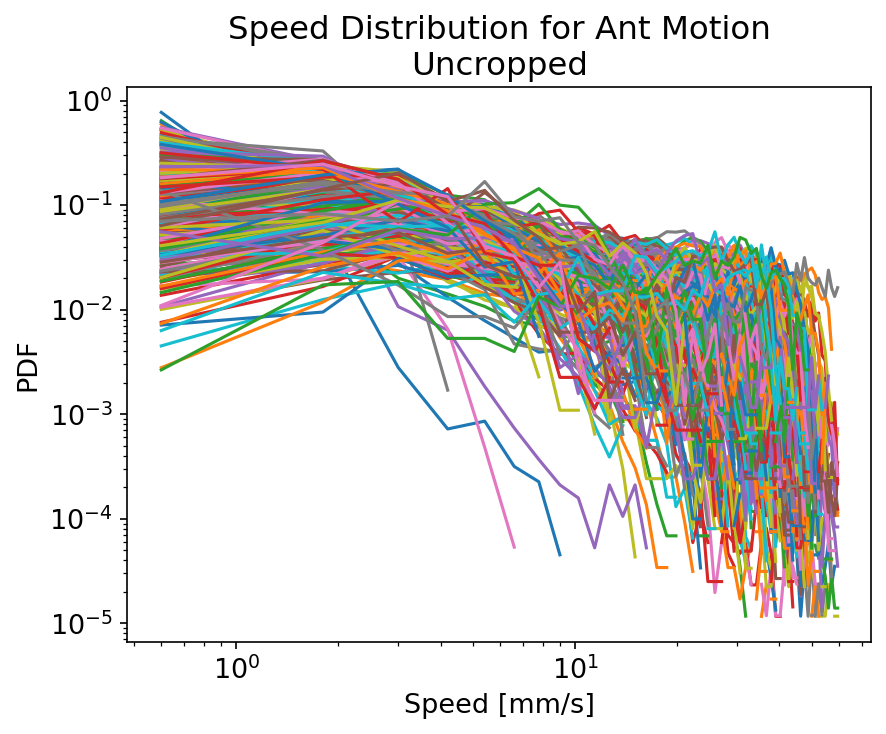

In [38]:
#plt.axvline(5, linestyle='--', c='gray')

for i in range(len(goodIndices)):
   #plt.plot(binArr / meanSpeedArr[i], np.where(speedDistArr[i], speedDistArr[i], np.nan), alpha=0.1)
   plt.plot(binArr, np.where(speedDistArr[i], speedDistArr[i], np.nan))#, alpha=0.1)

#meanDist, meanBins = np.histogram(allSpeedArr, bins=bins, density=True)
#meanBins = (meanBins[1:] + meanBins[:-1])/2

#plt.plot(meanBins, meanDist, '-o', c='black')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('PDF')
plt.xlabel('Speed [mm/s]')
plt.title('Speed Distribution for Ant Motion\nUncropped')
#plt.title('Speed Distribution for Ant Motion\nCropped at walls (1cm)')
#pltsaveall('05_RawVelocityDist')#_NoWalls')
plt.show()

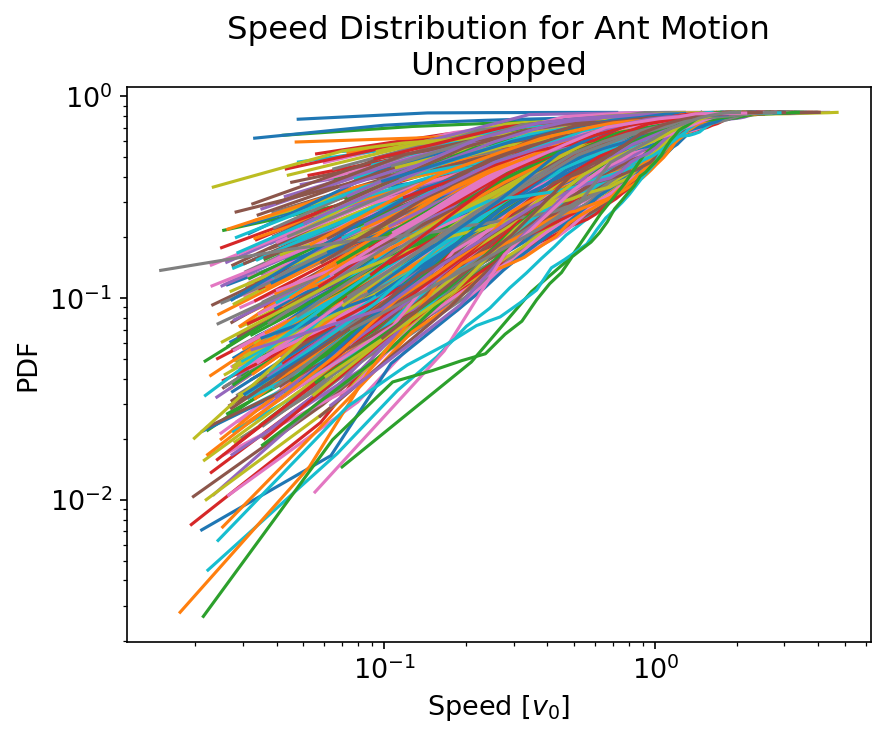

In [47]:
#plt.axvline(5, linestyle='--', c='gray')

for i in range(len(goodIndices)):
   plt.plot(binArr / meanSpeedArr[i], np.cumsum(np.where(speedDistArr[i], speedDistArr[i], np.nan)))#, alpha=0.1)
   #plt.plot(binArr, np.where(speedDistArr[i], speedDistArr[i], np.nan), alpha=0.1)

#meanDist, meanBins = np.histogram(allSpeedArr, bins=bins, density=True)
#meanBins = (meanBins[1:] + meanBins[:-1])/2

#plt.plot(meanBins, meanDist, '-o', c='black')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('PDF')
plt.xlabel('Speed [$v_0$]')
plt.title('Speed Distribution for Ant Motion\nUncropped')
#plt.title('Speed Distribution for Ant Motion\nCropped at walls (1cm)')
#pltsaveall('05_RawVelocityDist')#_NoWalls')
plt.show()

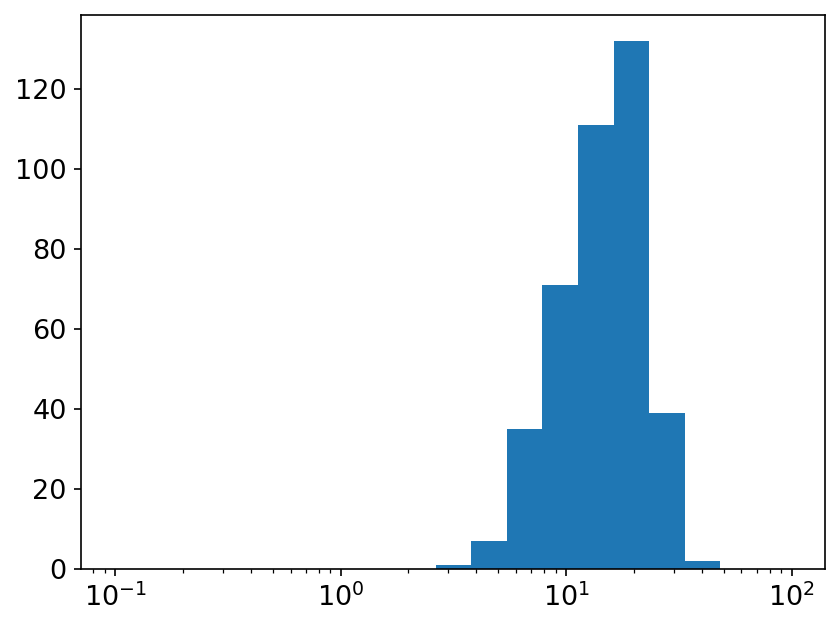

In [48]:
plt.hist(meanSpeedArr, bins=np.logspace(-1, 2, 20))
plt.xscale('log')
plt.show()

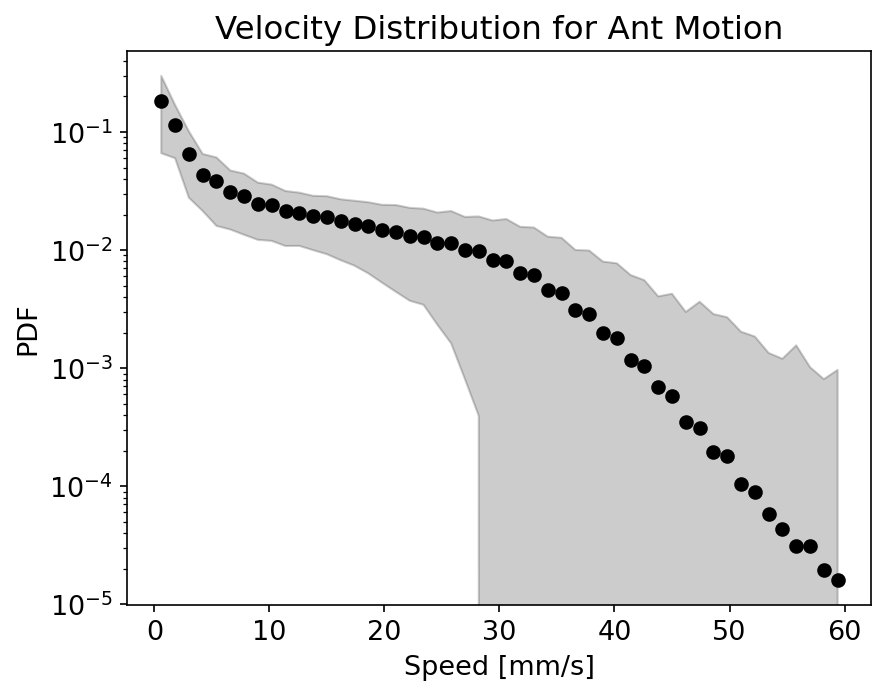

In [37]:
meanDist, meanBins = np.histogram(allSpeedArr, bins=bins, density=True)
meanBins = (meanBins[1:] + meanBins[:-1])/2

deviation = np.std(speedDistArr, axis=0)
plt.fill_between(binArr, meanDist - deviation, meanDist + deviation, alpha=0.2, color='black')
plt.scatter(meanBins, meanDist, c='black')


plt.yscale('log')
#plt.xscale('log')
plt.ylabel('PDF')
plt.xlabel('Speed [mm/s]')
#plt.title(f'Skip factor: {skipFactor}')
plt.title('Velocity Distribution for Ant Motion')#\nNo walls')
#plt.gcf().set_size_inches(5,2)
#plt.savefig('velocity.svg')
plt.show()